In [22]:
import numpy as np
import numpy.typing as npt
import json
import itertools
import matplotlib.pyplot as plt

from collections import defaultdict

from typing import Optional, List, Dict

import os
import pickle

In [23]:
def load_pickled_data(pickled_data_folder_path: str) -> List[npt.NDArray]:
    """
    Loads the data in the given path into a list of numpy arrays
    """
    data = []

    # for each data sample, there are 2 files (one with the data and one with the triggers)
    # additionally, apart from the regular data there are two files with training data
    NUM_OF_SAMPLES = (len(os.listdir(pickled_data_folder_path + "/data")) - 2) // 2
    for i in range(NUM_OF_SAMPLES):
        with open(f"{pickled_data_folder_path}/data/test_data_X_{i}.pkl", 'rb') as f:
            this_x = np.array(pickle.load(f))
        
        with open(f"{pickled_data_folder_path}/data/test_data_X_{i}_trigs.pkl", 'rb') as f:
            this_trigs = np.array(pickle.load(f))
            
        data.append(this_x[0, :, :])
    
    # validate all samples have 6 electrodes
    assert all(x.shape[1] == 6 for x in data)

    return data

In [24]:
def to_selection_times(data: List[npt.NDArray]) -> List[float]:
    """
    Given a list of data and assuming each sample is the data from one classification,
    converts it to a list of durations, how long it took to do a classification
    """
    SAMPLING_FREQUENCY = 1000 # Hz
    selection_times = [x.shape[0] / SAMPLING_FREQUENCY for x in data]
    assert len(selection_times) == len(data)

    return selection_times

In [25]:
def extract_selections(trials_json_path: str) -> List[int]:
    """
    Given the path to the trials.json file, extracts the classified options 
    and returns them as a list
    """
    with open(trials_json_path, "r") as file:
        experiment_json = json.load(file)
        
    selections = []
    for scenario in experiment_json:
        if experiment_json[scenario]['scenario'] == "Training scenario. Please follow the experimenter's instructions.":
            continue
        
        for trial in experiment_json[scenario]['trials']:
            selections.append(experiment_json[scenario]['trials'][trial]['kw_choice'])

    return selections

In [26]:
def group_selection_times_by_selection(selections: List[int], selection_times: List[float]) -> Dict[int, List[float]]:
    """
    Given the classified selections and the selection_times, ASSUMING BOTH ARE IN THE SAME ORDER,
    returns a dictionary which groups the selection_times by the classified selection
    """
    assert len(selections) == len(selection_times)
    result = defaultdict(list)
    
    for selection, time in zip(selections, selection_times):
        result[selection].append(time)

    return result

In [27]:
def remove_selection(grouped_selections: Dict[int, List[float]], option_id: int) -> List[float]:
    """
    Given the grouped selection and the id to be removed returns a list of only the selections without the id
    """
    return list(itertools.chain.from_iterable([grouped_selections[key] for key in grouped_selections if key != option_id]))

In [28]:
def do_analysis(pickled_data_folder_path: str, trials_json_path: str, correction: str = None):
    """
    Do and print the analysis of a single subject.

    Also accepts an optional correction argument, which corrects the data in some way
     - this is used as the experiment crashed for some subjects and some data may be invalid

    Returns the times to classify, grouped by the classification
    """
    
    
    data = load_pickled_data(pickled_data_folder_path)

    if correction == "s4":
        # remove data at index 12 and 13; invalid due to crash
        data.pop(12)
        data.pop(12) # list is one shorter, so shifted to the left
    
    elif correction == "s5":
        # remove data at index 83; invalid due to crash
        data.pop(83)

    print(f"Number of system interactions: {len(data)}")
    print(f"Shape of first data point: {data[0].shape}")

    selection_times = to_selection_times(data)

    selections = extract_selections(trials_json_path)
    assert len(data) == len(selections), f"data: {len(data)} vs. selections: {len(selections)}"

    print(f"Avg. selection time: {np.average(selection_times)}")
    print(f"Std. selection time: {np.std(selection_times)}")

    grouped_selections = group_selection_times_by_selection(selections, selection_times)
    # pretty print
    for key in np.sort(list(grouped_selections.keys())):
        print(f"===={key}====")
        item = grouped_selections[key]
        print(len(item))
        print(np.average(item))
        print(np.std(item))
        print("----------------------")
    print("----------------------")


    # get the average and standard deviation without the 'Finished' selection
    FINISHED_ID = 9
    without_finished = remove_selection(grouped_selections, FINISHED_ID)
    print(f"Avg. selection time (without finished): {np.average(without_finished)}")
    print(f"Std. selection time (without finished): {np.std(without_finished)}")

    plt.title("Selection times including finished")
    plt.hist(selection_times, bins=20)
    plt.show()

    plt.title("Selection times excluding finished")
    plt.hist(without_finished, bins=20)
    plt.show()

    plt.title("Selection times only finished")
    plt.hist(grouped_selections[FINISHED_ID], bins=20)
    plt.show()

    return grouped_selections

# Subject 1

In [29]:
target1 = "/run/media/zakm00/My Passport/z025_eeg_bai/subject1_2023-07-10_09-40-40"
target_selections1 = "/run/media/zakm00/My Passport/z025_eeg_bai/subject1_2023-07-10_09-40-40/subject1_2023-07-10_09-40-40_trials.json"

Number of system interactions: 96
Shape of first data point: (7843, 6)
Avg. selection time: 5.371708333333333
Std. selection time: 3.2463577376444337
====0====
21
4.641619047619049
2.946820085580395
----------------------
====1====
19
5.859157894736842
3.652263988025393
----------------------
====2====
7
7.828
2.416345765229566
----------------------
====3====
6
4.714666666666666
2.178243839018539
----------------------
====4====
3
5.375333333333334
3.1217401486279335
----------------------
====5====
6
5.390333333333333
3.2820216161519853
----------------------
====6====
11
4.610727272727273
3.301497100928307
----------------------
====7====
11
4.123272727272727
2.3448303714926544
----------------------
====8====
4
4.68975
3.7995778959642346
----------------------
====9====
8
7.562625
2.5071548584750407
----------------------
----------------------
Avg. selection time (without finished): 5.1725340909090916
Std. selection time (without finished): 3.232558053155369


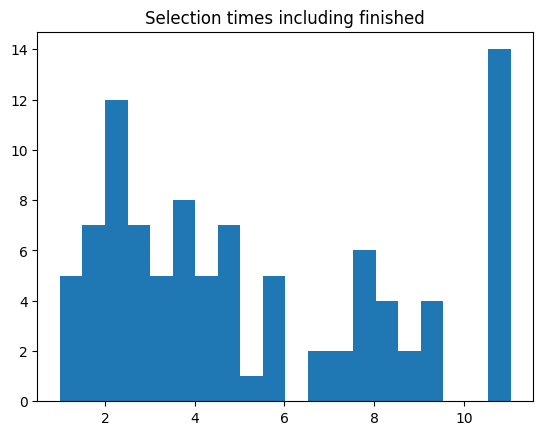

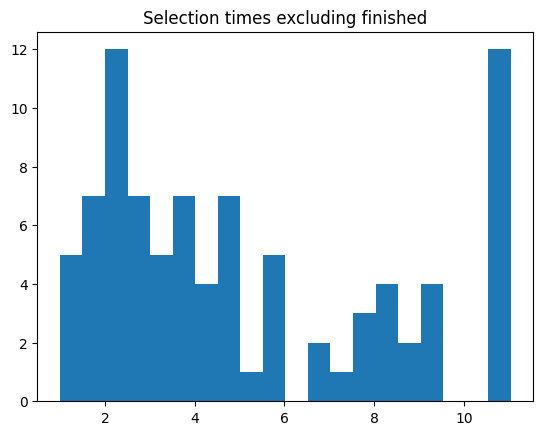

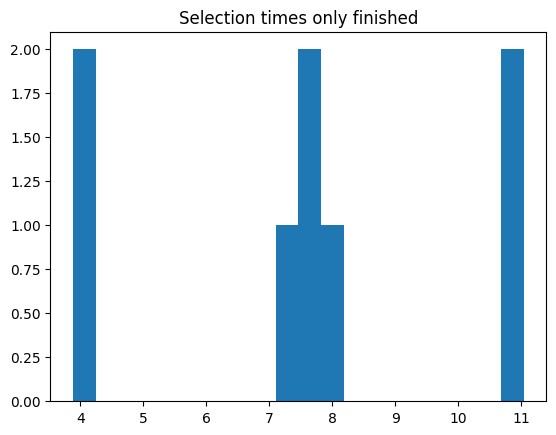

In [30]:
s1_results = do_analysis(target1, target_selections1)

# Subject 2

In [31]:
target2 = "/run/media/zakm00/My Passport/z025_eeg_bai/subject2_2023-07-11_16-24-51"
target_selections2 = "/run/media/zakm00/My Passport/z025_eeg_bai/subject2_2023-07-11_16-24-51/subject2_2023-07-11_16-24-51_trials_old.json"

Number of system interactions: 81
Shape of first data point: (5750, 6)
Avg. selection time: 3.7116913580246913
Std. selection time: 2.7136002491427402
====0====
12
3.029
2.6385493173332955
----------------------
====1====
14
3.310714285714286
2.293638607371373
----------------------
====2====
9
2.322111111111111
1.4549303491877728
----------------------
====3====
7
4.071428571428572
3.135494622960187
----------------------
====4====
6
3.7916666666666665
2.0837499583416643
----------------------
====5====
4
2.4625000000000004
1.0218702217013667
----------------------
====6====
4
4.0375
4.089831139545984
----------------------
====7====
13
4.184615384615385
2.273119223867758
----------------------
====8====
4
4.25
3.983246163620823
----------------------
====9====
8
6.050000000000001
2.317730571054367
----------------------
----------------------
Avg. selection time (without finished): 3.4554383561643838
Std. selection time (without finished): 2.6300258969832933


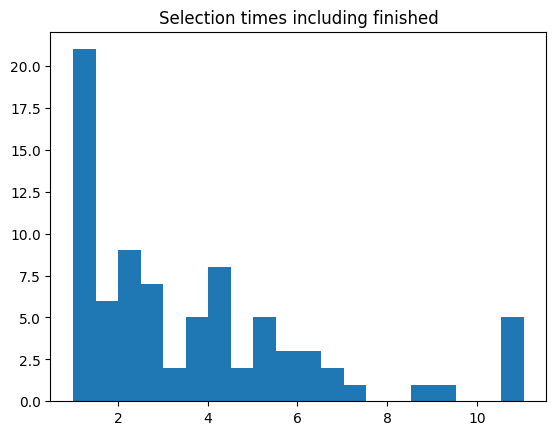

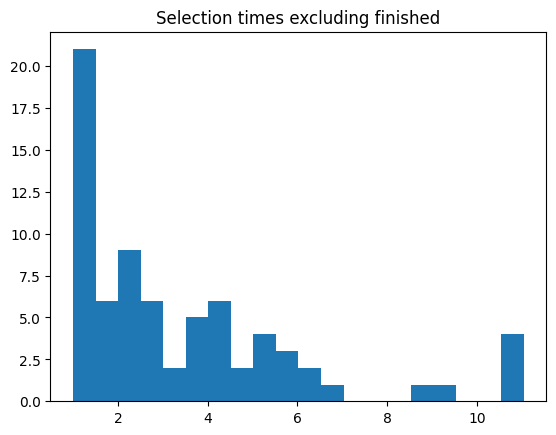

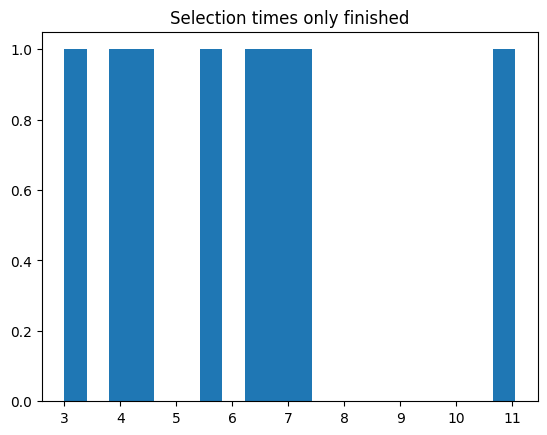

In [32]:
s2_results = do_analysis(target2, target_selections2)

# Subject 3

In [33]:
target3 = "/run/media/zakm00/My Passport/z025_eeg_bai/subject3_2023-07-13_10-33-20"
target_selections3 = "/run/media/zakm00/My Passport/z025_eeg_bai/subject3_2023-07-13_10-33-20/subject3_2023-07-13_10-33-20_trials.json"

Number of system interactions: 73
Shape of first data point: (4050, 6)
Avg. selection time: 2.232109589041096
Std. selection time: 1.1558554984061467
====0====
13
1.8846153846153848
0.7461141940296703
----------------------
====1====
9
2.6666666666666665
1.601388286595242
----------------------
====2====
6
2.0248333333333335
0.9708673813772003
----------------------
====3====
7
1.892857142857143
0.6956130756537058
----------------------
====4====
7
1.55
0.89880873541435
----------------------
====5====
4
1.9874999999999998
0.4435298749802543
----------------------
====6====
3
1.0666666666666667
0.06236095644623232
----------------------
====7====
10
2.6247999999999996
1.2211409255282537
----------------------
====8====
5
2.3798000000000004
1.444697947669339
----------------------
====9====
9
3.210888888888889
0.6823517249507104
----------------------
----------------------
Avg. selection time (without finished): 2.09446875
Std. selection time (without finished): 1.1422506972085584


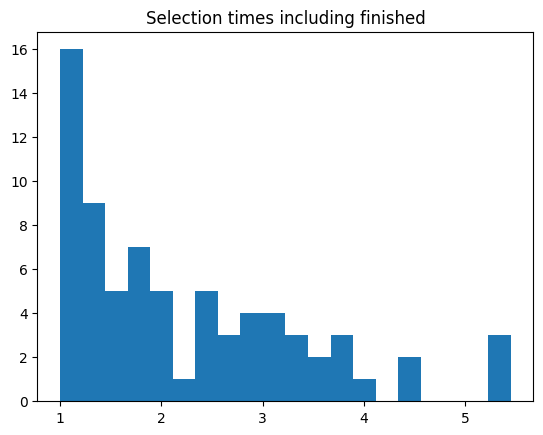

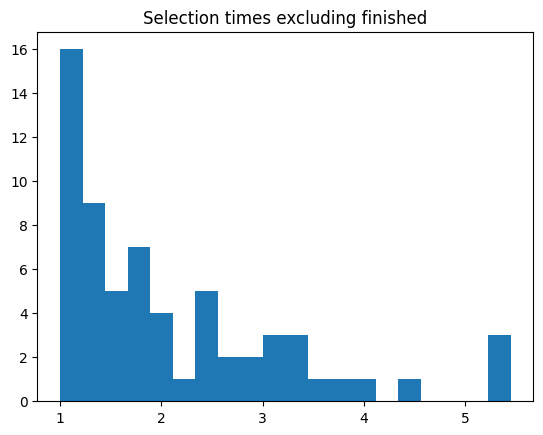

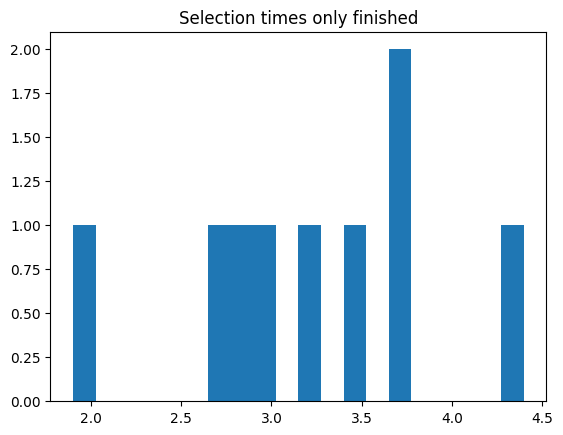

In [34]:
s3_results = do_analysis(target3, target_selections3)

# Subject 4

In [35]:
target4 = "/run/media/zakm00/My Passport/z025_eeg_bai/subject4_2023-07-17_12-37-35"
target_selections4 = "/run/media/zakm00/My Passport/z025_eeg_bai/subject4_2023-07-17_12-37-35/subject4_2023-07-17_12-37-35_trials.json"

Number of system interactions: 70
Shape of first data point: (1700, 6)
Avg. selection time: 2.6844142857142854
Std. selection time: 1.9991427197880678
====0====
12
2.375083333333333
1.3287290580559388
----------------------
====1====
8
2.3877499999999996
1.2670735722522193
----------------------
====2====
6
1.7251666666666665
0.5896327717788044
----------------------
====3====
8
1.893875
0.7551987217779172
----------------------
====4====
7
1.7002857142857142
0.6949823665359564
----------------------
====5====
6
3.5083333333333333
2.713763786494486
----------------------
====6====
2
2.45
1.3
----------------------
====7====
9
2.4223333333333334
1.1916615850707504
----------------------
====8====
3
1.2666666666666666
0.22484562605386738
----------------------
====9====
9
5.705666666666667
2.6471328724573775
----------------------
----------------------
Avg. selection time (without finished): 2.2386557377049185
Std. selection time (without finished): 1.4166559896315274


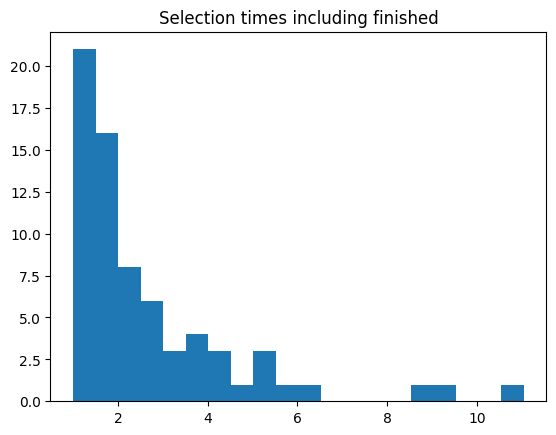

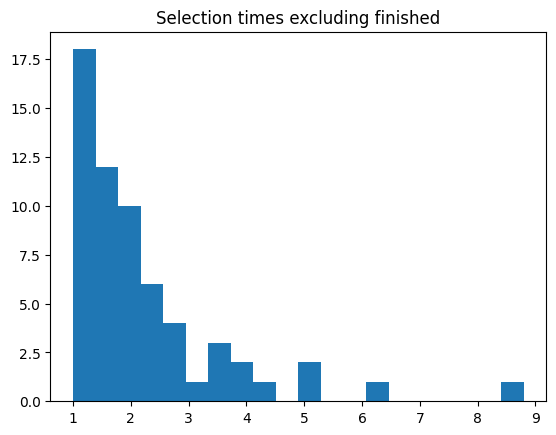

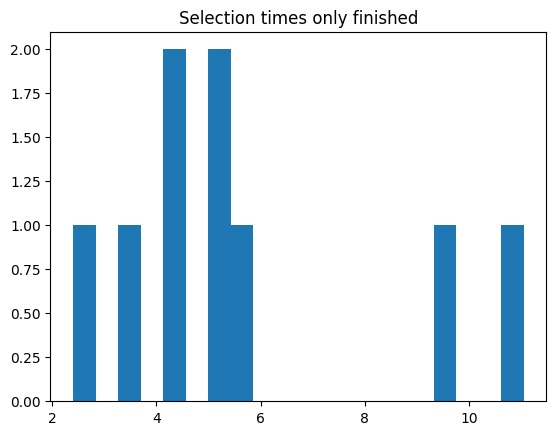

In [36]:
s4_results = do_analysis(target4, target_selections4, correction="s4")

# Subject 5

In [37]:
target5 = "/run/media/zakm00/My Passport/z025_eeg_bai/subject5_2023-07-25_10-28-17"
target_selections5 = "/run/media/zakm00/My Passport/z025_eeg_bai/subject5_2023-07-25_10-28-17/subject5_2023-07-25_10-28-17_trials.json"

Number of system interactions: 98
Shape of first data point: (11050, 6)
Avg. selection time: 9.689785714285714
Std. selection time: 2.5514983443107324
====0====
16
10.440875
1.4853992255871822
----------------------
====1====
18
9.63327777777778
2.5775975852968975
----------------------
====2====
10
10.174800000000001
1.7389408155541122
----------------------
====3====
8
9.424875
2.463976736776344
----------------------
====4====
11
9.313545454545455
2.6644406325338763
----------------------
====5====
6
10.483333333333334
1.0225241100118647
----------------------
====6====
7
8.214285714285714
3.5497197359906645
----------------------
====7====
10
10.149899999999999
1.537959716637598
----------------------
====8====
5
7.0304
4.92380103578526
----------------------
====9====
7
10.357000000000001
1.3980781707145606
----------------------
----------------------
Avg. selection time (without finished): 9.638461538461536
Std. selection time (without finished): 2.6122193852455386


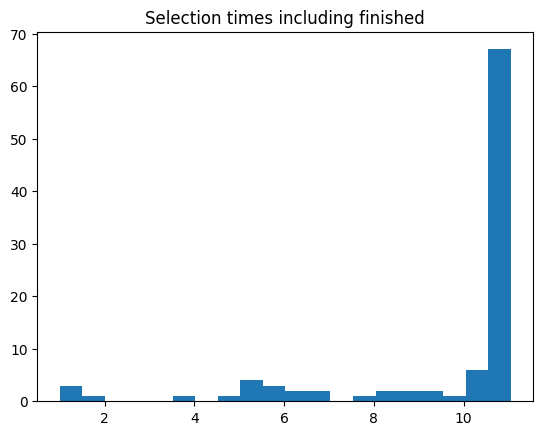

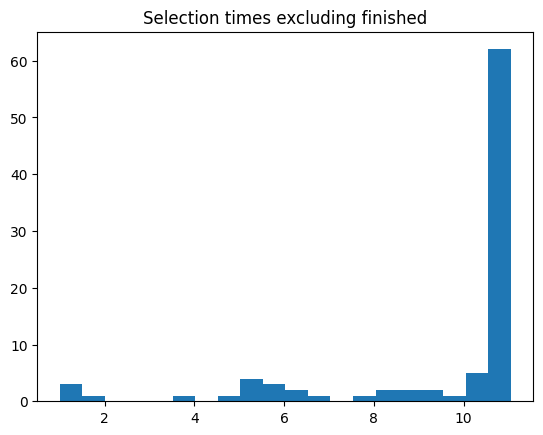

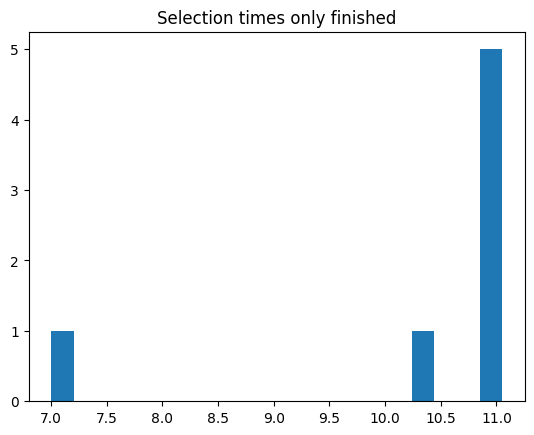

In [38]:
s5_results = do_analysis(target5, target_selections5, correction="s5")

# Common analysis

In [39]:
common_result = {}
for key in s1_results.keys():
    common_result[key] = s1_results[key]
    common_result[key] += s2_results[key]
    common_result[key] += s3_results[key]
    common_result[key] += s4_results[key]
    common_result[key] += s5_results[key]

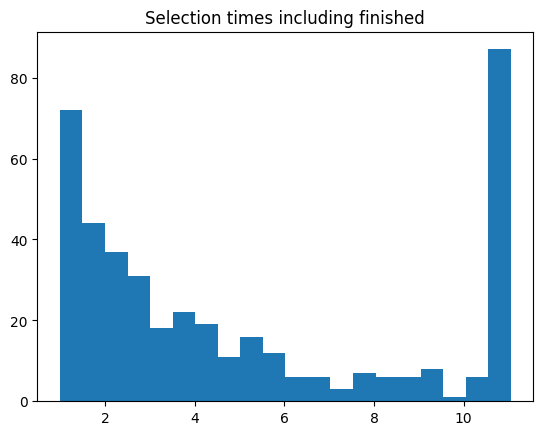

In [40]:
plt.title("Selection times including finished")
plt.hist(list(itertools.chain.from_iterable(common_result.values())), bins=20)
plt.show()

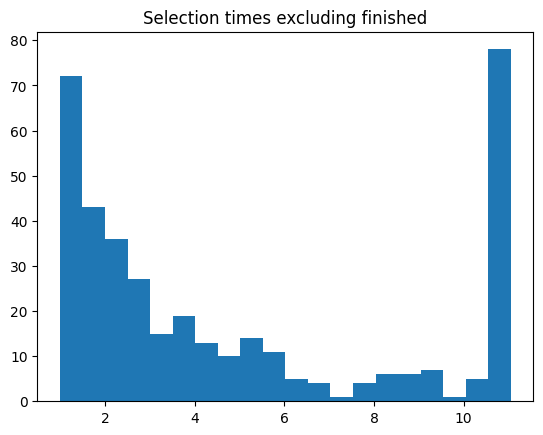

In [41]:
result_no_finished = common_result.copy()
result_no_finished.pop(9, None)

plt.title("Selection times excluding finished")
plt.hist(list(itertools.chain.from_iterable(result_no_finished.values())), bins=20)
plt.show()

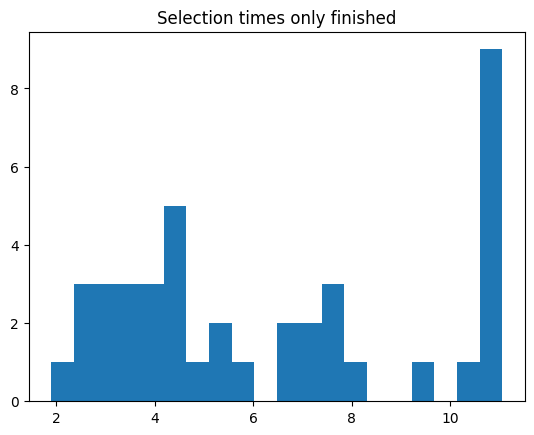

In [42]:
plt.title("Selection times only finished")
plt.hist(common_result[9], bins=20)
plt.show()